# Analyse de la qualité des données

## Prise de connaissance avec le jeu de données

### Chargement des données brut

In [1]:
from getting_started import df_patient, df_pcr, pd

df_patient = df_patient.convert_dtypes()
df_pcr = df_pcr.convert_dtypes()

In [2]:
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   patient_id     20000 non-null  Int64 
 1   given_name     19560 non-null  string
 2   surname        19575 non-null  string
 3   street_number  19618 non-null  Int64 
 4   address_1      19204 non-null  string
 5   suburb         19788 non-null  string
 6   postcode       19801 non-null  string
 7   state          18010 non-null  string
 8   date_of_birth  17989 non-null  Int64 
 9   age            16003 non-null  Int64 
 10  phone_number   19081 non-null  string
 11  address_2      7893 non-null   string
dtypes: Int64(4), string(8)
memory usage: 1.9 MB


In [3]:
df_pcr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  8800 non-null   Int64 
 1   pcr         8800 non-null   string
dtypes: Int64(1), string(1)
memory usage: 146.2 KB


On définit l'identifiant métier `patient_id` comme index du référentiel.

In [4]:
df_patient.set_index("patient_id", inplace=True, verify_integrity=True)

ValueError: Index has duplicate keys: Index([119816, 328071, 521818, 844149, 411955, 289139, 645735, 303196, 441383,
       692632,
       ...
       865523, 115791, 230436, 339647, 890144, 961465, 520331, 563609, 535564,
       605950],
      dtype='object', name='patient_id', length=201)

La définition de l'index échoue ce qui indique la présence de doublons dans l'identifiant. Cela justifie une analyse approfondie de la qualité du référentiel.

### Doublons dans l'identifiant

In [5]:
df_patient[df_patient.duplicated("patient_id", keep=False)].sort_values("patient_id")

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
12117,109304,zachary,farronato,30,outtrim avenue,como,2196,vic,19090801,31,07 22894061,the reefs
14839,109304,bailey,donaldson,20,tardent street,ryde,0812,qld,19580310,26,07 13479210,<NA>
4386,110207,toby,brock,4,merriman crescent,baralaba,3025,nsw,19000424,35,08 33842007,leitrim
12989,110207,zali,brock,32,hedger street,toorak,5038,act,<NA>,22,08 96818512,<NA>
10184,115791,hannah,clarke,70,galmarra street,mayfield,7010,vic,19830828,25,04 70760611,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...
10507,990695,erin,braunack,49,moondarra street,broken hill,2640,qld,19830122,30,03 69523317,yuulong
8764,990936,amy,royle,90,whittell crescent,coramba,5032,sa,19950326,<NA>,08 07309295,tewantin plaza
12563,990936,samantha,green,21,brierly street,ardrossan,2140,<NA>,19380210,29,02 51600621,<NA>
2385,994235,trent,stewart-jones,129,macfarland crescent,wangaratta,2732,nsw,<NA>,<NA>,07 98662458,mountview


Il y a 403 patients qui doublonnent sur l'identifiant à supprimer.

In [6]:
df_patient.drop_duplicates("patient_id", keep=False, inplace=True)
df_patient.set_index("patient_id", inplace=True)

df_patient.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19597 entries, 221958 to 925217
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   given_name     19168 non-null  string
 1   surname        19178 non-null  string
 2   street_number  19223 non-null  Int64 
 3   address_1      18816 non-null  string
 4   suburb         19394 non-null  string
 5   postcode       19403 non-null  string
 6   state          17647 non-null  string
 7   date_of_birth  17622 non-null  Int64 
 8   age            15681 non-null  Int64 
 9   phone_number   18694 non-null  string
 10  address_2      7725 non-null   string
dtypes: Int64(3), string(8)
memory usage: 1.9+ MB


### Doublons sur l'ensemble des attributs

In [7]:
df_patient[df_patient.duplicated(keep=False)].sort_values("surname")

,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
patient_id,,,,,,,,,,,
804259,charlie,gamlin,33,nungara street,bayswater,5251,qld,19190111,24,04 33326042,<NA>
107928,charlie,gamlin,33,nungara street,bayswater,5251,qld,19190111,24,04 33326042,<NA>
449738,freya,jaffres,50,hart place,biggera waters,4413,wa,<NA>,33,07 76055136,<NA>
744576,freya,jaffres,50,hart place,biggera waters,4413,wa,<NA>,33,07 76055136,<NA>
373129,delaney,kermeen,9,wallen place,st kilda east,4405,qld,19391226,25,08 37919311,<NA>
973030,delaney,kermeen,9,wallen place,st kilda east,4405,qld,19391226,25,08 37919311,<NA>
421721,samantha,laundy,2,mannheim street,quairading,4740,qld,19480111,<NA>,02 37735421,stanton
664037,samantha,laundy,2,mannheim street,quairading,4740,qld,19480111,<NA>,02 37735421,stanton
669936,lewis,matthews,24,allawah flats,attunga,3216,wa,19690623,26,03 95122427,<NA>


Il y 22 patients qui doublonnent sur l'ensemble des attributs.

Il faudra donc définir une stratégie de rapprochement de certains patients du référentiel. 

### Attributs non renseignés

In [8]:
df_patient.notna().sum() / len(df_patient)

given_name       0.978109
surname          0.978619
street_number    0.980915
address_1        0.960147
suburb           0.989641
postcode         0.990101
state            0.900495
date_of_birth    0.899219
age              0.800173
phone_number     0.953922
address_2        0.394193
dtype: float64

Le second champ d'adresse est très peu renseigné (~40%) par rapport aux autres.

<AxesSubplot:xlabel='attributs non renseignés', ylabel='patients'>

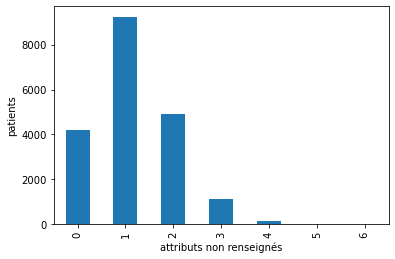

In [9]:
df_patient_isna = df_patient.isna()

df_patient_isna.sum(axis="columns").value_counts().sort_index().plot.bar(xlabel="attributs non renseignés", ylabel="patients")

La majorité des patients ont jusqu'à 3 attributs non renseignés.



Distribution des attributs non renseignés pour les cas extêmes:

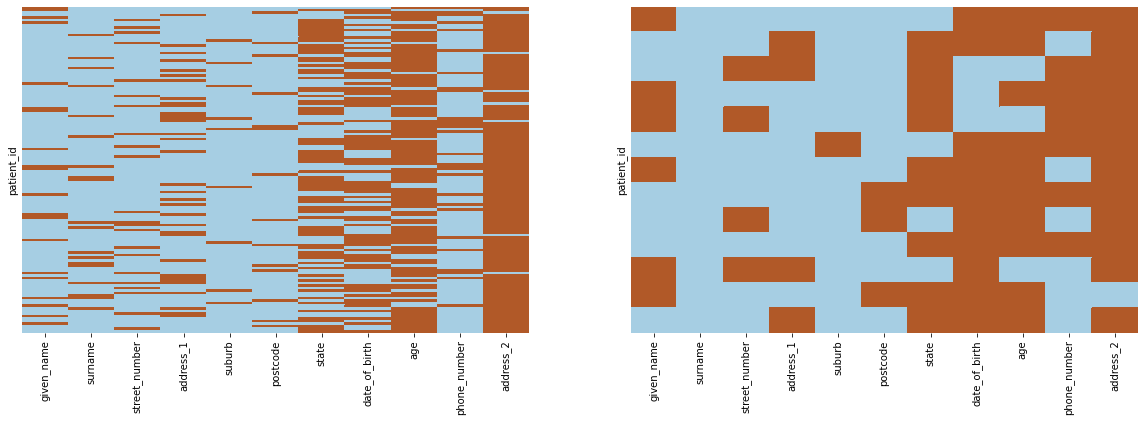

In [10]:
import matplotlib.pyplot as plt
from seaborn import heatmap

plot_kwargs = dict(cmap="Paired", cbar=False, yticklabels=False)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)
heatmap(df_patient_isna[df_patient_isna.sum(axis="columns") == 4], ax=ax[0], **plot_kwargs)
heatmap(df_patient_isna[df_patient_isna.sum(axis="columns") > 4], ax=ax[1], **plot_kwargs)
plt.show()

Dans ces cas là, il faudra définir des rapprochements spécifiques en fonction des attributs fiables disponibles.

## Analyse de l'échantillon de tests PCR

### Répartition des valeurs

In [11]:
df_pcr.pcr.value_counts()

N           3482
Negative    3134
Positive    1283
P            901
Name: pcr, dtype: Int64

Deux conventions sont utilisées pour représenter les deux valeurs possibles d'un test PCR (négatif ou positif) : `N / P` et `Negative / Positive`.

On préfèrera normaliser ces résultats dans une variable catégorielle.

In [12]:
df_pcr.pcr = df_pcr.pcr.str[0].astype(pd.CategoricalDtype(categories={"N", "P"}))

df_pcr.pcr.value_counts()

N    6616
P    2184
Name: pcr, dtype: int64

### Exhaustivité du référentiel

Le référentiel de patients n'est pas exhaustif.

In [13]:
df_pcr.patient_id.drop_duplicates().isin(df_patient.index).all()

False

Il y aura 168 tests supprimés à l'issue de la jointure avec le référentiel, dont 43 positifs.

In [14]:
df_pcr[~df_pcr.patient_id.isin(df_patient.index)].pcr.value_counts()

N    125
P     43
Name: pcr, dtype: int64

## Analyse du référenciel de patients

### Numéro de téléphone

En [Australie](https://info.australia.gov.au/about-australia/facts-and-figures/telephone-country-and-area-codes), les numéro de téléphone sont composés d'un indicatif régional sur 2 chiffres, suivi d'un indicatif local sur 8 chiffres.

Séparation des indicatifs régionaux et locaux :

In [15]:
df_patient_phone_number = (
    df_patient.phone_number.dropna()
    .str.extract(r"(\d{2})\s(\d{8})", expand=True)
    .rename(columns={0: "area", 1: "local"})
)

df_patient_phone_number.sample(10, random_state=42)

,area,local
patient_id,,
883849,08,92442075
509995,07,24840644
116138,02,70300700
282058,04,73461732
253043,03,12982403
495556,04,32517461
705842,03,60926320
846111,02,54530686
848224,07,35968163


Vérification de la validité des indicatifs régionaux :

In [16]:
df_patient_phone_number.area.isin(["02", "03", "04", "07", "08"]).all()

True

Le numéro de téléphone est fiable, a une forte valeur d'identification et est souvent renseigné.

On s'en servira pour les rapprochements flous.

### Nom et prénom

#### Valeurs manquantes

In [17]:
df_patient[["surname", "given_name"]].isna().value_counts()

surname  given_name
False    False         18753
         True            425
True     False           415
         True              4
dtype: int64

Il y a 861 patients dont le nom et / ou le prénom ne sont pas renseignés.

#### Fautes de saisie

On procède à un rapprochement via le numéro de téléphone et calcule la similarité entre les nom et prénom renseignés.

La mesure de similarité choisie est la distance de Damerau-Levenshtein car elle est particulièrement adaptée pour détecter les fautes humaines qui peuvent arriver lors de la saisie répétée de texte brut, dont l'inversion ou la substitution de caractères.

L'hypothèse est qu'une distance faible corresponde à une faute typographique. Une distance élévée soulèvera d'autres fautes de saisie.

Rapprochement des patients doublonnés sur leur numéro de téléphone

In [18]:
where_phone_number_duplicated = df_patient.phone_number.duplicated(keep=False)

df = df_patient[where_phone_number_duplicated].dropna(subset={"phone_number"})

df = (
    df[["given_name", "surname", "phone_number"]]
    .dropna(subset={"phone_number"})
    .reset_index()
)

df["full_name"] = df[["given_name", "surname"]].fillna("").sum(axis=1)

df = df.merge(df, on="phone_number").drop_duplicates("patient_id_x")

Calcul de la distance d'édition

In [19]:
from textdistance import damerau_levenshtein

df["distance"] = df.apply(lambda x: damerau_levenshtein(x.full_name_x, x.full_name_y), axis=1)

df = df[df.distance >= 1]

Distribution de la similarité

<AxesSubplot:>

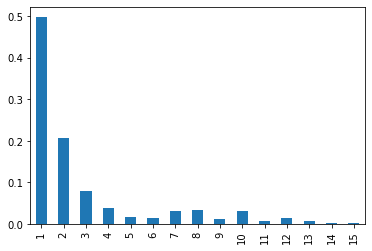

In [20]:
df.distance.value_counts(normalize=True).sort_index().plot.bar()

Une forte proportion des patients rapprochés ont une faible distance d'édition.

J'évalue la valeur charnière distinguant les fautes typographiques des autres erreurs à 4

In [21]:
df[df.distance < 4].sample(10, random_state=42)

,patient_id_x,given_name_x,surname_x,phone_number,full_name_x,patient_id_y,given_name_y,surname_y,full_name_y,distance
1025,233964,giuliaaa,robson,02 54377445,giuliaaarobson,924690,giuliana,robsgn,giulianarobsgn,2
3414,934233,charlotte,ruskin,04 85107991,charlotteruskin,712439,charlotte,rusmin,charlotterusmin,1
652,676231,matthew,coxob,03 69841288,matthewcoxob,871954,matthew,coxon,matthewcoxon,1
324,963517,steven,hazell,08 35040193,stevenhazell,218015,stveen,haaell,stveenhaaell,2
4841,775371,chelsea,martinovic,02 12938957,chelseamartinovic,280680,chelsea,martincvic,chelseamartincvic,1
4914,687270,seth,perre,04 23323948,sethperre,413612,seth,perte,sethperte,1
4705,223554,hannsh,secomb,08 79959512,hannshsecomb,668423,hannah,secomb,hannahsecomb,1
853,757011,jacob,vaccaro,08 81376824,jacobvaccaro,502662,jacov,vaccafjo,jacovvaccafjo,3
2938,800399,abb,matthews,04 88982844,abbmatthews,863461,abby,matthews,abbymatthews,1
109,683984,madeline,lomman,04 49295527,madelinelomman,384806,madelibe,lomman,madelibelomman,1


On retrouve les fautes typographiques classiques:
- Substitution de un ou plusieurs caractères
- Ajout ou suppression de caractères

In [22]:
df[df.distance == 4].sample(20, random_state=42)

,patient_id_x,given_name_x,surname_x,phone_number,full_name_x,patient_id_y,given_name_y,surname_y,full_name_y,distance
2628,130257,tara,hoffman,02 41170093,tarahoffman,509064,<NA>,hoffman,hoffman,4
2087,742480,matthew,snell,03 65051480,matthewsnell,697218,mathias,snell,mathiassnell,4
659,216841,livvie,zarevac,08 87474386,livviezarevac,311791,olivia,zarevax,oliviazarevax,4
2084,135525,matthew,snell,03 65051480,matthewsnell,697218,mathias,snell,mathiassnell,4
3090,135135,joshua,grooby,03 91305817,joshuagrooby,932595,jlsh,grodby,jlshgrodby,4
2490,503561,thokas,dreyer,08 15210915,thokasdreyer,188668,tot,dreyer,totdreyer,4
755,460701,cassody,twang,08 61745219,cassodytwang,859224,cassandra,twang,cassandratwang,4
2494,783753,thomas,dreyer,08 15210915,thomasdreyer,188668,tot,dreyer,totdreyer,4
1550,609850,emiily,rimsky-korsakov,02 23986599,emiilyrimsky-korsakov,490530,millie,rimsky-korsakov,millierimsky-korsakov,4
816,853753,shakira,white,07 46137414,shakirawhite,866641,schkirra,whitf,schkirrawhitf,4


On retrouve un mélange de fautes typographiques plus importantes sur le nom et le prénom, mais aussi des subsitutions de prénom au profit d'une version plus courte ou plus familière (olivia -> livvie, anastasia -> stacia).

In [23]:
df[df.distance > 4].sample(20, random_state=42)

,patient_id_x,given_name_x,surname_x,phone_number,full_name_x,patient_id_y,given_name_y,surname_y,full_name_y,distance
3757,174191,ruby,reinmuth,03 16346080,rubyreinmuth,145256,reinmuth,ruby,reinmuthruby,8
411,259132,ethan,matthews,07 14141423,ethanmatthews,990617,matthews,ethn,matthewsethn,9
294,198723,george,carlim,08 02954691,georgecarlim,271890,carlib,george,carlibgeorge,11
3973,494861,ballantyne,jordan,02 13710140,ballantynejordan,898204,jordan,ballantyne,jordanballantyne,12
3024,231004,robin,kradolfer,04 77969146,robinkradolfer,701891,<NA>,kradolfr,kradolfr,6
3192,885566,blunden,alana,08 43878781,blundenalana,720273,alana,blunden,alanablunden,10
1614,254607,max,wilkins,02 17609707,maxwilkins,947982,max,needham,maxneedham,7
2436,668178,lucy,wohltkwnn,04 78582346,lucywohltkwnn,262002,lucida,wohltmann,lucidawohltmann,5
4581,234278,joel,jedzsnk,03 20660740,joeljedzsnk,661669,jol,jedynaek,joljedynaek,5
414,955783,ethan,matthews,07 14141423,ethanmatthews,990617,matthews,ethn,matthewsethn,9


Pour les fortes distances, on retrouve des inversions de nom et prénom et des noms différents.

## Âge et date de naissance

### Valeurs manquantes

In [24]:
df_patient[["date_of_birth", "age"]].isna().value_counts()

date_of_birth  age  
False          False    14096
               True      3526
True           False     1585
               True       390
dtype: int64

### Répartition des âges

In [25]:
df_patient.age.describe()

count    15681.000000
mean        27.527199
std          7.817141
min          0.000000
25%         24.000000
50%         29.000000
75%         33.000000
max         92.000000
Name: age, dtype: float64

<AxesSubplot:xlabel="catégorie d'âge", ylabel='patients'>

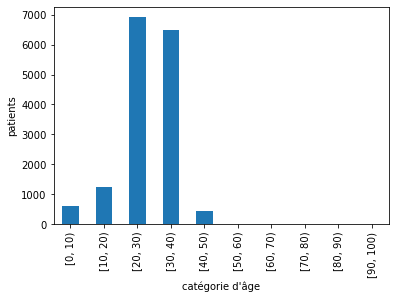

In [26]:
df_patient_age = pd.cut(df_patient.age.dropna(), bins=range(0, 101, 10), right=False)

df_patient_age.value_counts().sort_index().plot.bar(xlabel="catégorie d'âge", ylabel="patients")

<AxesSubplot:xlabel='âge', ylabel='patients'>

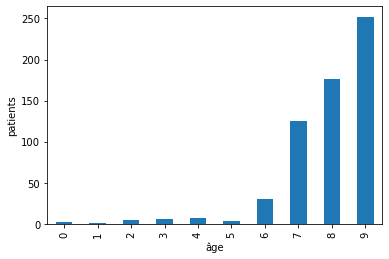

In [27]:
df_patient[df_patient.age < 10].age.value_counts().sort_index().plot.bar(xlabel="âge", ylabel="patients")

On remarquera la présence de quelques patients en très bas âge (inférieur à 6 ans).

Je n'ai pas connaissance d'un quelconque âge minimum pour effectuer un test PCR (à confirmer auprès d'un expert).

### Dates de naissance invalides

La date de naissance est stockée au format `YYYYMMDD` dans une valeur entière.

On la convertit en `datetime` afin de la valider.

In [28]:
date_of_birth = df_patient.date_of_birth.copy()

df_patient.date_of_birth = pd.to_datetime(df_patient.date_of_birth, format="%Y%M%d", errors="coerce")

dob_invalid = date_of_birth[df_patient.date_of_birth.isna()].dropna()

dob_invalid

patient_id
627035    19030539
921654    19179318
691460    19541242
584299    19990353
200235    19328814
            ...   
499158    19679825
801346    19339919
687453    19550480
434796    19910237
916593    19120978
Name: date_of_birth, Length: 106, dtype: Int64

Il y a 106 patients dont la date de naissance est non conforme.

In [29]:
dob_invalid_split = (
    dob_invalid.astype(str)
    .str.extract(r"(\d{4})(\d{2})(\d{2})", expand=True)
    .rename(columns={0: "year", 1: "month", 2: "day"})
    .astype(int)
)

dob_invalid_split.sample(10, random_state=42)

,year,month,day
patient_id,,,
136509,1920,0,88
567010,1974,94,17
200235,1932,88,14
759390,1969,92,20
644043,1997,4,41
570066,1976,3,91
381696,1990,80,17
345144,1902,1,50
902914,1905,11,42


L'échantillon montre la présence de valeurs aberrantes pour l'année, le mois et le jour.

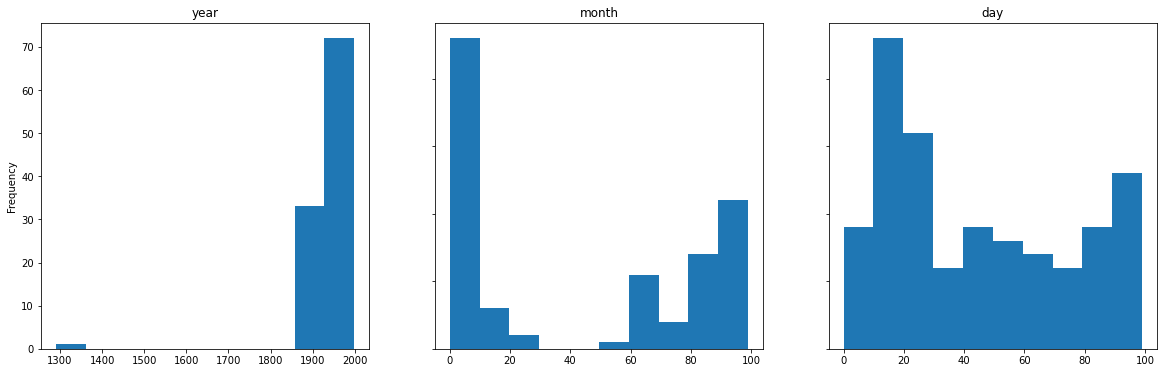

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 6)
dob_invalid_split.year.plot.hist(title="year", ax=ax[0], sharey=True)
dob_invalid_split.month.plot.hist(title="month", ax=ax[1], sharey=True)
dob_invalid_split.day.plot.hist(title="day", ax=ax[2], sharey=True)
plt.show()

### Incohérence entre date de naissance et âge renseigné

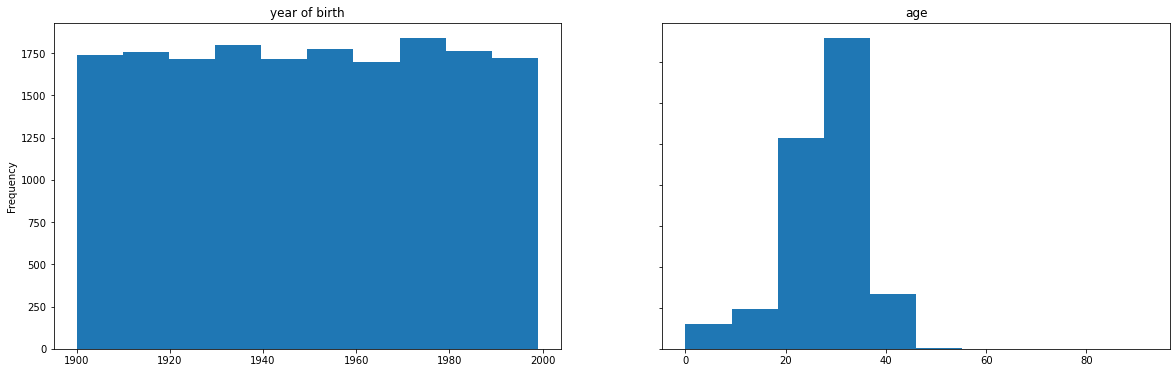

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)
df_patient.date_of_birth.dt.year.plot.hist(title="year of birth", ax=ax[0], sharey=True)
df_patient.age.plot.hist(title="age", ax=ax[1], sharey=True)

plt.show()

Les distributions de l'année de naissance et de l'âge ne concordent pas. La date de naissance est incohérente avec l'âge renseigné.

## Adresse personnelle

### Numéro de rue

La numérotation des rues démarrent à 1. Le minimum de 0 est une valeur erronée.

In [32]:
df_patient.street_number.dropna().astype(int).describe()

count     19223.000000
mean         99.248504
std        2506.948241
min           0.000000
25%          10.000000
50%          24.000000
75%          60.000000
max      342951.000000
Name: street_number, dtype: float64

Analyse du nombre de chiffres composant le numéro de rue.

<AxesSubplot:xlabel='digits in street number', ylabel='patients'>

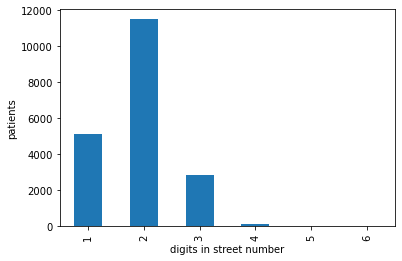

In [33]:
street_number = df_patient.street_number.fillna(0).dropna().astype(int)
street_number["number_of_digits"] = street_number.astype(str).str.len()

street_number.number_of_digits.value_counts().sort_index().plot.bar(xlabel="digits in street number", ylabel="patients")


Il y a quelques patients avec un numéro de rue exceptionnellement élevé (nombre de chiffres >= 5).

On analyse les patients correspondant.

In [34]:
df_patient_with_large_street_number = df_patient.loc[street_number.number_of_digits >= 5]

df_patient_with_large_street_number[["street_number", "address_1", "phone_number"]]

,street_number,address_1,phone_number
patient_id,,,
869217,342951,taylor place,08 37654995
278130,10030,galway place,02 26956185
446997,39430,airey crescent,02 15333991
955542,11575,arrietta close,03 46121237
232871,12569,streeton drive,04 25029200


Les patients ont tous un numéro de téléphone renseigné.

On peut donc effectuer un rapprochement par celui-ci afin d'identifier une possible erreur de saisie.

In [35]:
df1 = df_patient_with_large_street_number[
    ["street_number", "address_1", "phone_number"]
].reset_index()

df2 = df_patient[
    ["street_number", "address_1", "phone_number"]
].reset_index()

df1 = df1.merge(df2, on="phone_number")

df1.loc[df1.patient_id_x != df1.patient_id_y]

,patient_id_x,street_number_x,address_1_x,phone_number,patient_id_y,street_number_y,address_1_y
0,869217,342951,taylor place,08 37654995,827975,3429,taylor place
1,869217,342951,taylor place,08 37654995,221789,3429,taylor place
3,869217,342951,taylor place,08 37654995,978087,3429,taylor place
4,278130,10030,galway place,02 26956185,893567,1000,galway place
6,278130,10030,galway place,02 26956185,813304,1000,galway place


Le numéro de rue à 6 chiffres est une erreur de saisie (342951 -> 3429).

Idem pour l'un des numéro de rue à 5 chiffres (10030 -> 1000).

### Adresse

#### Taux de remplissage

In [36]:
df_patient[["address_1", "address_2"]].notna().value_counts(normalize=True).sort_index()

address_1  address_2
False      False        0.023320
           True         0.016533
True       False        0.582487
           True         0.377660
dtype: float64

- 96% des adresses ont au moins le premier champ d'adresse renseigné
- 38% ont les deux champs renseignés

#### Fautes de saisie

Rapprochement des adresses de patient partageant un même numéro de téléphone.

In [37]:
address = (
    df_patient[["address_1", "address_2", "phone_number"]]
        .reset_index()
        .dropna(subset=["phone_number"])
        .fillna("<NA>")
)
address["full_address"] = address[["address_1", "address_2"]].apply(", ".join, axis=1)
address = address.merge(address, on="phone_number")
address = address.loc[
    (address.patient_id_x != address.patient_id_y) & \
    (address.full_address_x != address.full_address_y)
]

address.sort_values(by=["phone_number", "patient_id_x"]).head(10)

,patient_id_x,address_1_x,address_2_x,phone_number,full_address_x,patient_id_y,address_1_y,address_2_y,full_address_y
4045,210155,mcnicollyplace,<NA>,02 00325977,"mcnicollyplace, <NA>",311830,mcnicoll place,<NA>,"mcnicoll place, <NA>"
4047,210155,mcnicollyplace,<NA>,02 00325977,"mcnicollyplace, <NA>",525466,mcnicoll place,<NA>,"mcnicoll place, <NA>"
4043,311830,mcnicoll place,<NA>,02 00325977,"mcnicoll place, <NA>",210155,mcnicollyplace,<NA>,"mcnicollyplace, <NA>"
4049,525466,mcnicoll place,<NA>,02 00325977,"mcnicoll place, <NA>",210155,mcnicollyplace,<NA>,"mcnicollyplace, <NA>"
976,123387,bunurung close,<NA>,02 01272164,"bunurung close, <NA>",505218,bunurunqaqclose,<NA>,"bunurunqaqclose, <NA>"
984,375877,bunurung close,<NA>,02 01272164,"bunurung close, <NA>",505218,bunurunqaqclose,<NA>,"bunurunqaqclose, <NA>"
972,431593,bunurung close,<NA>,02 01272164,"bunurung close, <NA>",505218,bunurunqaqclose,<NA>,"bunurunqaqclose, <NA>"
978,505218,bunurunqaqclose,<NA>,02 01272164,"bunurunqaqclose, <NA>",431593,bunurung close,<NA>,"bunurung close, <NA>"
979,505218,bunurunqaqclose,<NA>,02 01272164,"bunurunqaqclose, <NA>",123387,bunurung close,<NA>,"bunurung close, <NA>"
981,505218,bunurunqaqclose,<NA>,02 01272164,"bunurunqaqclose, <NA>",375877,bunurung close,<NA>,"bunurung close, <NA>"


Calcul de la distance d'édition.

<AxesSubplot:>

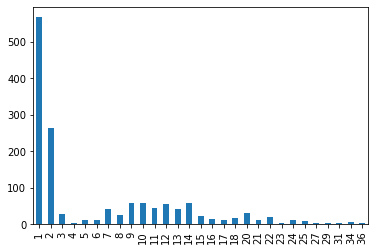

In [38]:
address["distance"] = address.apply(
    lambda x: damerau_levenshtein(x.full_address_x, x.full_address_y),
    axis=1
)

address.distance.value_counts().sort_index().plot.bar()

Fautes typographiques.

In [39]:
address.loc[address.distance <= 2, ["full_address_x", "full_address_y", "distance"]].sample(20, random_state=42)

,full_address_x,full_address_y,distance
9607,"nungara street, <NA>","nungara ztreet, <NA>",1
18191,"morgan crescent, mt butler street","morgan crescent, mt butler tsreet",1
3525,"carter crescent, <NA>","carter creccent, <NA>",1
7960,"mclachlan crescent, <NA>","mclachlan cfescent, <NA>",1
2259,"federal zighway, marungi park","federal highway, marungi park",1
11064,"hoseason street, <NA>","hoseasonistreet, <NA>",1
18188,"morgan crescent, mt butler street","morgan crescent, mt butler tsreet",1
1267,"academy close, <NA>","academg close, <NA>",1
3169,"griffith p lace, cantlay farm","griffithpjlace, cantlay farm",2
7698,"greenvale jtreet, <NA>","greenvale street, <NA>",1


In [40]:
address.loc[address.distance == 3, ["full_address_x", "full_address_y", "distance"]]

,full_address_x,full_address_y,distance
972,"bunurung close, <NA>","bunurunqaqclose, <NA>",3
976,"bunurung close, <NA>","bunurunqaqclose, <NA>",3
978,"bunurunqaqclose, <NA>","bunurung close, <NA>",3
979,"bunurunqaqclose, <NA>","bunurung close, <NA>",3
981,"bunurunqaqclose, <NA>","bunurung close, <NA>",3
984,"bunurung close, <NA>","bunurunqaqclose, <NA>",3
1731,"mccaughey street, narraburra lodge","mccaughey stbeet, narrabburralodge",3
1733,"mccaughey stbeet, narrabburralodge","mccaughey street, narraburra lodge",3
1735,"mccaughey stbeet, narrabburralodge","mccaughey street, narraburra lodge",3
1737,"mccaughey street, narraburra lodge","mccaughey stbeet, narrabburralodge",3


In [41]:
address.loc[address.distance == 4, ["full_address_x", "full_address_y", "distance"]]

,full_address_x,full_address_y,distance
3846,"quirosdtreet, yaroknga","quiros street, yaroonha",4
3850,"quiros street, yaroonha","quirosdtreet, yaroknga",4
4545,"birdwoods reet, <NA>","birdwoosbctreet, <NA>",4
4547,"birdwoosbctreet, <NA>","birdwoods reet, <NA>",4


Autres fautes.


In [42]:
address.loc[address.distance > 4, ["full_address_x", "full_address_y", "distance"]].sample(30, random_state=42)

,full_address_x,full_address_y,distance
13239,"wrixon street, <NA>","john clelanddcrescent, 1st hse past (rhs)",34
10092,"hattersley court, mulgunna","hattersley court, <NA>",8
8562,"<NA>, rowethorpe trinity hostel","bavin street, <NA>",25
1073,"hurley street, <NA>","kirwan icrcuit, <NA>",10
6128,"maranoa street, <NA>","<NA>, <NA>",14
2015,"higinbotham street, myranda","higinbotham street, <NA>",7
4377,"yelland place, <NA>","yelland place, appollonia hse",14
4492,"ainslie ravenue, ochr","ainslie avenue, <NA>",5
1366,"wolgal place, cherry haven","cherry haven, wolgal place",20
15394,"totterdely street, yreek bishops","totterdell street, bishops creek",13


### Quartier

Certains couples quartier / postcode ont été inversées lors de la saisie.

In [43]:
df_patient.loc[df_patient.suburb.str.contains(r"\d")]

,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
patient_id,,,,,,,,,,,
810644,juliana,grosvenor,5,connelly pace,3023,port noarlunga south,tas,1999-01-15 00:12:00,<NA>,03 55227740,<NA>
986559,kirra,choi-lundberg,102,centaurus street,6168,naremburn,vic,1926-01-04 00:11:00,27,08 69584599,<NA>
752873,lochlan,blake,258,<NA>,4216,toowoobma,wa,1908-01-21 00:08:00,31,02 84630666,<NA>
902348,isaac,nakoje,19,collier street,6017,brighton,<NA>,1964-01-21 00:04:00,8,02 69439226,<NA>
678110,jaden,green,5,dovey place,3185,oraneg,vic,1915-01-04 00:12:00,23,02 73534391,<NA>
690348,andrew,ryan,20,mainwaring rich circuit,3020,blacktown,wa,1976-01-01 00:00:00,22,<NA>,<NA>
727290,tiffany,loukes,31,leal place,467l0,forest hill,nsw,1976-01-06 00:07:00,23,<NA>,pangani
738103,hugi,pascoe,167,leita court,3023,port lincoln,nsw,1904-01-01 00:04:00,<NA>,07 84786511,<NA>
684359,sonia,green,50,kalgoorlie crescent,6112,ashfield,sa,NaT,9,03 46671647,<NA>


Pour ces patients, il faut procéder à l'inversion des valeurs du quartier et du code postal.

Le code postal peut contenir un caractère alphabétique qu'il faudra supprimer (exemple `467l0` -> `4670`).

In [44]:
to_swap = df_patient.loc[df_patient.suburb.str.contains(r"\d"), ["suburb", "postcode"]]

to_swap["suburb"], to_swap["postcode"] = to_swap["postcode"], to_swap["suburb"]

to_swap["postcode"] = to_swap["postcode"].str.replace(r"[a-z]", "")

df_patient.update(to_swap)

df_patient.loc[to_swap.index, ["suburb", "postcode"]]

,suburb,postcode
patient_id,,
810644,port noarlunga south,3023
986559,naremburn,6168
752873,toowoobma,4216
902348,brighton,6017
678110,oraneg,3185
690348,blacktown,3020
727290,forest hill,4670
738103,port lincoln,3023
684359,ashfield,6112


### État

L'Australie compte 8 états et territoires codés de la manière suivante :

In [45]:
STATES = {'act', 'nsw', 'nt', 'qld', 'sa', 'tas', 'vic', 'wa'}

Répartition des valeurs de code d'état.

In [46]:
state_counts = df_patient.state.value_counts()

On retrouve les codes des 8 états de l'Australie.

In [47]:
state_counts.head(8)

nsw    6030
vic    4246
qld    3456
wa     1553
sa     1362
tas     495
act     242
nt      127
Name: state, dtype: Int64

Et d'autres codes d'état à rectifier.

In [48]:
state_counts[8:]

nss     7
ns      6
ws      6
ql      5
nsq     4
       ..
qlt     1
vil     1
vicf    1
nlw     1
nssw    1
Name: state, Length: 93, dtype: Int64

On effectue un premier rapprochement flou sur une distance d'édition très courte.

Les rapprochements ambigüs (code -> \[état\]) seront supprimés.

In [49]:
from itertools import product
from textdistance import damerau_levenshtein

states = STATES
codes = set(state_counts.index) - STATES

df_distance = pd.Series(
    data=[damerau_levenshtein(c, s) for c, s in product(codes, states)],
    index=pd.MultiIndex.from_product([codes, states], names=["code", "state"]),
    name="distance",
)

code_to_state = dict(
    df_distance[df_distance == 1].index.to_frame()
    .drop_duplicates(subset="code", keep=False).index
)

code_to_state

{'nse': 'nsw',
 'ql': 'qld',
 'nsn': 'nsw',
 'vkc': 'vic',
 'ws': 'wa',
 'viv': 'vic',
 'nswb': 'nsw',
 'qle': 'qld',
 'fsw': 'nsw',
 'vil': 'vic',
 'vicm': 'vic',
 'nsxw': 'nsw',
 'qlz': 'qld',
 'qlg': 'qld',
 'tad': 'tas',
 'nsc': 'nsw',
 'gic': 'vic',
 'vicf': 'vic',
 'qlh': 'qld',
 'wz': 'wa',
 'qln': 'qld',
 'tab': 'tas',
 'vc': 'vic',
 'qkd': 'qld',
 'vix': 'vic',
 'qldg': 'qld',
 'nswt': 'nsw',
 'nsew': 'nsw',
 'vicb': 'vic',
 'nlw': 'nsw',
 'nu': 'nt',
 'qdd': 'qld',
 'nswn': 'nsw',
 'qud': 'qld',
 'tak': 'tas',
 'wab': 'wa',
 'nsy': 'nsw',
 'nssw': 'nsw',
 'vi': 'vic',
 'vif': 'vic',
 'qlf': 'qld',
 'qls': 'qld',
 'vib': 'vic',
 'qod': 'qld',
 'nfw': 'nsw',
 'ng': 'nt',
 'qlc': 'qld',
 'w': 'wa',
 'nswm': 'nsw',
 'wu': 'wa',
 'taz': 'tas',
 'nfsw': 'nsw',
 'wq': 'wa',
 'qlr': 'qld',
 'nsq': 'nsw',
 'nxw': 'nsw',
 'vid': 'vic',
 'vicw': 'vic',
 'qldy': 'qld',
 'vicz': 'vic',
 'nsd': 'nsw',
 'sv': 'sa',
 'waw': 'wa',
 'nsg': 'nsw',
 'vich': 'vic',
 's': 'sa',
 'nss': 'nsw',
 'ql

Codes d'état non rapprochés

In [50]:
codes_to_na = codes - set(code_to_state.keys())

codes_to_na

{'a',
 'ai',
 'ns',
 'nsa',
 'nsgs',
 'nsjh',
 'nsza',
 'nvq',
 'nwd',
 'nwx',
 'nze',
 'qxlj',
 'ta',
 'vcci',
 'vh',
 'vmv',
 'vq',
 'vucm',
 'vuv'}

Correction des états.

In [51]:
code_to_state.update({c: pd.NA for c in codes_to_na})
df_patient.state.replace(code_to_state, inplace=True)

df_patient.state.value_counts()

nsw    6066
vic    4269
qld    3482
wa     1568
sa     1365
tas     499
act     242
nt      130
Name: state, dtype: int64

### Code postal

#### Taux de remplissage dans l'adresse

In [52]:
df_patient[["postcode", "suburb", "state"]].notna().value_counts(sort=False)

postcode  suburb  state
False     False   True         1
          True    False       16
                  True       177
True      False   False       20
                  True       182
          True    False     1940
                  True     17261
dtype: int64

Le code postal est très souvent renseigné, accompagné du quartier et / ou de l'état.   

#### Validation

Tous les code postaux renseignés respectent le format Australien sur 4 chiffres.

In [53]:
(~df_patient.dropna().postcode.str.contains(r"\d{4}")).sum()

0

Chargement du référentiel de codes postaux valides par état.

_Compilé des données de cet [article](https://en.wikipedia.org/w/index.php?title=Postcodes_in_Australia)_

In [54]:
state_postcode_ranges = pd.read_csv("state_postcode.csv").convert_dtypes()

state_postcode_ranges

,state,postcode_min_range,postcode_max_range
0,act,200,299
1,nt,800,999
2,nsw,1000,1999
3,nsw,2000,2599
4,act,2600,2618
5,nsw,2619,2899
6,act,2900,2920
7,nsw,2921,2999
8,vic,3000,3999
9,qld,4000,4999


Codes postaux invalides hors considération de l'état

In [55]:
postcodes = df_patient.postcode.dropna().unique()

postcode_range = pd.arrays.IntervalArray.from_arrays(
    left=state_postcode_ranges.postcode_min_range.astype(int),
    right=state_postcode_ranges.postcode_max_range.astype(int),
    closed="both",
)

validate_postcode = lambda p: postcode_range.contains(int(p)).any()

invalid_postcodes = [p for p in postcodes if not validate_postcode(p)]

df_patient.postcode.replace({p: pd.NA for p in invalid_postcodes})

invalid_postcodes

['6798']

Codes postaux invalides avec considération de l'état

In [56]:
postcode_ranges_per_state = {
    state: pd.arrays.IntervalArray.from_arrays(
        left=postcode.postcode_min_range,
        right=postcode.postcode_max_range,
        closed="both",
    )
    for state, postcode
    in state_postcode_ranges.groupby(by="state").agg(tuple).iterrows()
}

validate_state_postcode = lambda s, p: postcode_ranges_per_state[s].contains(int(p)).any()

df_patient[["state", "postcode"]].dropna().apply(
    lambda x: not validate_state_postcode(x.state, x.postcode),
    axis="columns"
).value_counts(normalize=True)

True     0.770395
False    0.229605
dtype: float64

Une large proportion de codes postaux sont incohérents avec l'état renseigné (77%).

Il sera nécessaire de corriger l'état renseigné avec le code postal.